In [4]:

import numpy as np
import math
import time
import warnings
import matplotlib.pyplot as plt
import random
import cv2
import cProfile
from PIL import Image
import copy
from scipy.ndimage import gaussian_filter
from skimage.measure import block_reduce
from collections import deque

import sys
sys.path.append('./PYmodule')
import itertools
from scipy.optimize import minimize

from kdtree import KDTree
from node import Node

from scipy import stats

from tune import tune_gs

from int_plot import int_plot_error,int_sliceviewer

#from int_plot_loc import int_sliceviewer_loc


GLOBAL_SEED = 42


# 5. Restart from here
## load data

In [5]:

# load trimmed data
nc_sample=np.load('npy/save_nc_sample.npy')
nc_empty=np.load('npy/save_nc_empty.npy')
mask=np.load('npy/save_mask.npy')

# read simulated peak from gen_sim_peak.ipynb
nc_simpeak=np.load('npy/save_nc_simpeak.npy')
nc_simpeak_withbg=nc_simpeak+nc_empty


bg_kdtree=np.load('npy/save_bg_kdtree.npy')
br_sample=np.load('npy/save_br_sample.npy')
br_simpeak=np.load('npy/save_br_simpeak.npy')


## original data vs cleaned data

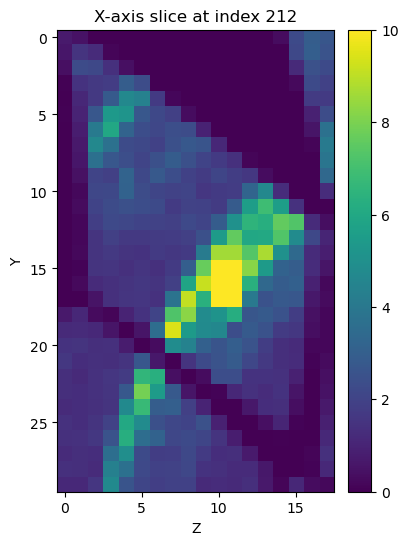

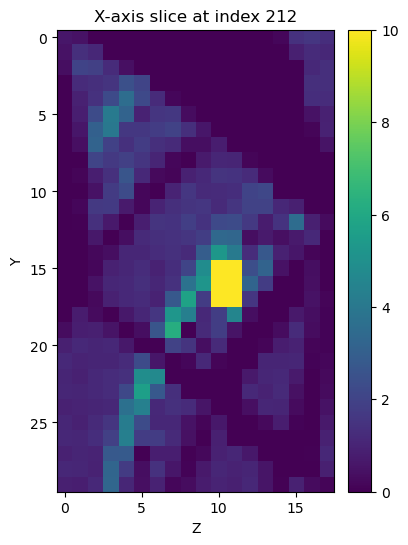

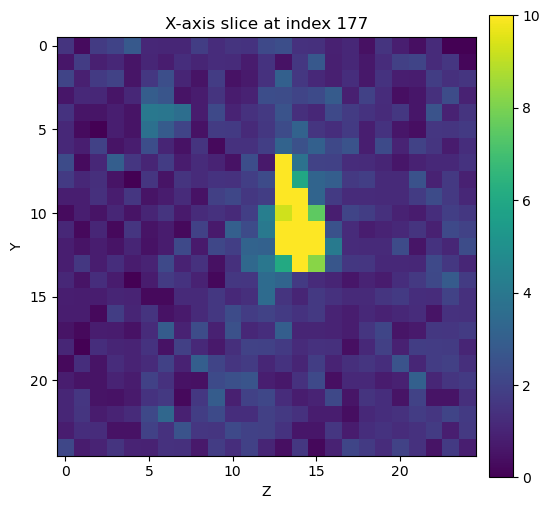

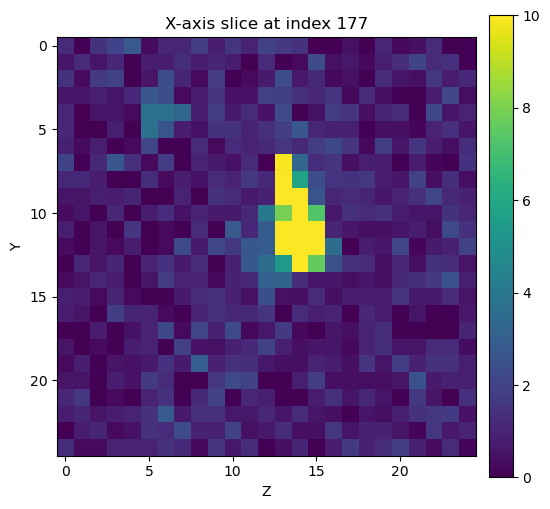

In [28]:
def plot_slice(data3d,axis, index,ymin,ymax,zmin,zmax,cbmax,scale_mode):
        plt.figure(figsize=(6, 6))
        if(scale_mode=='log' or scale_mode=='logit'):
            cbmin=0.1
        else:
            cbmin=0
        if axis == 'X':
            im=plt.imshow(data3d[index, ymin:ymax, zmin:zmax], cmap='viridis',vmin=cbmin,vmax=cbmax,norm=scale_mode)
           # im=plt.imshow(data3d[index, 200:240, 90:130], cmap='viridis',vmin=cbmin,vmax=cbmax,norm=scale_mode)
          #  im=plt.imshow(data3d[index, 210:235, 95:120], cmap='viridis',vmin=cbmin,vmax=cbmax,norm=scale_mode)
            plt.title(f'X-axis slice at index {index}')
            plt.xlabel('Z')
            plt.ylabel('Y')        
        elif axis == 'Y':
            im=plt.imshow(data3d[:, index, :], cmap='viridis',vmin=cbmin,vmax=cbmax,norm=scale_mode)
            plt.title(f'Y-axis slice at index {index}')
            plt.xlabel('Z')
            plt.ylabel('X')
        elif axis == 'Z':
            im=plt.imshow(data3d[:, :, index], cmap='viridis',vmin=cbmin,vmax=cbmax,norm=scale_mode)
            plt.title(f'Z-axis slice at index {index}')
            plt.xlabel('Y')
            plt.ylabel('X')
        plt.colorbar(im,fraction=0.07,pad=0.03)
        

    
        
        plt.show()

xind_slice=212
yind_min=210
yind_max=240
zind_min=207
zind_max=225
plot_slice(nc_sample,'X',xind_slice,ymin=yind_min,ymax=yind_max,zmin=zind_min,zmax=zind_max,cbmax=10,scale_mode='linear')

plot_slice(br_sample,'X',xind_slice,ymin=yind_min,ymax=yind_max,zmin=zind_min,zmax=zind_max,cbmax=10,scale_mode='linear')


#peak2 [166:180, 210:235, 95:120]
xind_slice=177
yind_min=210
yind_max=235
zind_min=95
zind_max=120
plot_slice(nc_sample,'X',xind_slice,ymin=yind_min,ymax=yind_max,zmin=zind_min,zmax=zind_max,cbmax=10,scale_mode='linear')
plot_slice(br_sample,'X',xind_slice,ymin=yind_min,ymax=yind_max,zmin=zind_min,zmax=zind_max,cbmax=10,scale_mode='linear')


## slice 

interactive(children=(IntSlider(value=226, description='X-Index:', max=500), IntSlider(value=226, description=…

<function __main__.plot_line(xind, yind)>

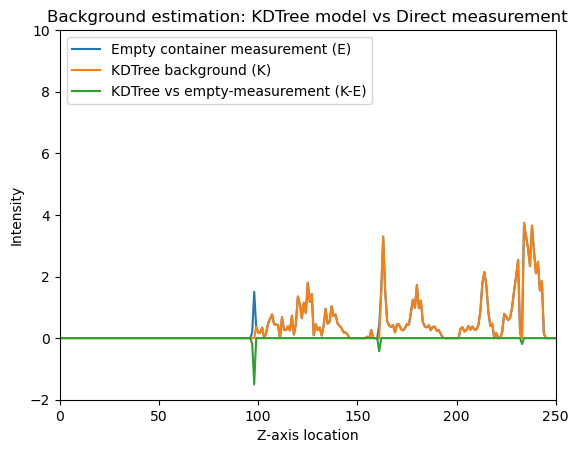

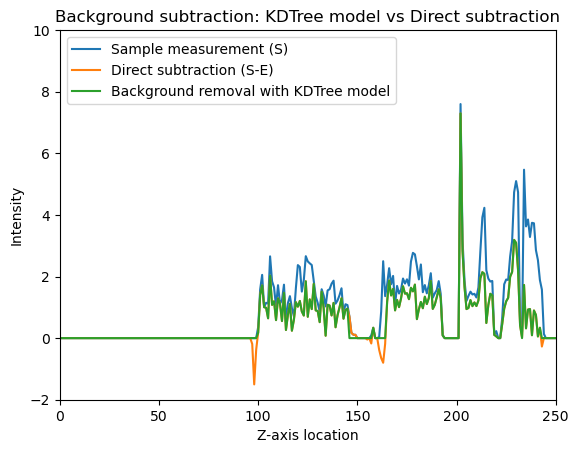

In [25]:

br_direct=nc_sample-nc_empty


from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def plot_line(xind,yind):

    zlen=nc_empty.shape[2]
    plt.plot(np.arange(zlen),nc_sample[xind,yind,:],label='Sample measurement (S)')
    plt.plot(np.arange(zlen),nc_empty[xind,yind,:],label='Empty measurement (E)')
    plt.plot(np.arange(zlen),bg_kdtree[xind,yind,:],label='KDTree background (K)')

    plt.plot(np.arange(zlen),(bg_kdtree- nc_empty)[xind,yind,:],label='KDTree vs empty-measurement (K-E)')
    plt.plot(np.arange(zlen),(nc_sample-nc_empty)[xind,yind,:],label='Direct subtraction (S-E)')
    plt.plot(np.arange(zlen),(br_sample)[xind,yind,:],label='Background removal with KDTree model')

    plt.ylim((-2,10))
    plt.xlabel('Z-axis location')
    plt.ylabel('Intensity')
    plt.title('Comparison between different methods')
    
    plt.xlim((200,250))
#    plt.legend(loc='outside upper center')
    plt.legend(loc='upper left')
    plt.show()


xindex_widget = widgets.IntSlider(min=0, max=500, step=1, value=226,description='X-Index:')
yindex_widget = widgets.IntSlider(min=0, max=500, step=1, value=226,description='Y-Index:')


widgets.interact(plot_line, xind=xindex_widget,yind=yindex_widget)


def plot_line_bg(xind,yind):

    zlen=nc_empty.shape[2]
    plt.plot(np.arange(zlen),nc_empty[xind,yind,:],label='Empty container measurement (E)')
    plt.plot(np.arange(zlen),bg_kdtree[xind,yind,:],label='KDTree background (K)')

    plt.plot(np.arange(zlen),(bg_kdtree- nc_empty)[xind,yind,:],label='KDTree vs empty-measurement (K-E)')

    plt.ylim((-2,10))
    plt.xlabel('Z-axis location')
    plt.ylabel('Intensity')
    plt.title('Background estimation: KDTree model vs Direct measurement')
    
    plt.xlim((00,250))
   # plt.xlim((80,120))
#    plt.legend(loc='outside upper center')
    plt.legend(loc='upper left')
    plt.show()


def plot_line_br(xind,yind):

    zlen=nc_empty.shape[2]
    
    plt.plot(np.arange(zlen),nc_sample[xind,yind,:],label='Sample measurement (S)')
    plt.plot(np.arange(zlen),(nc_sample-nc_empty)[xind,yind,:],label='Direct subtraction (S-E)')
    plt.plot(np.arange(zlen),(br_sample)[xind,yind,:],label='Background removal with KDTree model')

    plt.ylim((-2,10))
    plt.xlabel('Z-axis location')
    plt.ylabel('Intensity')
    plt.title('Background subtraction: KDTree model vs Direct subtraction')
    
    plt.xlim((00,250))
#    plt.legend(loc='outside upper center')
    plt.legend(loc='upper left')
    plt.show()

plot_line_bg(206,280)

plot_line_br(206,280)


Text(0.5, 1.0, 'X-axis slice at index 211')

Text(0.5, 0, 'Z')

Text(0, 0.5, 'Y')

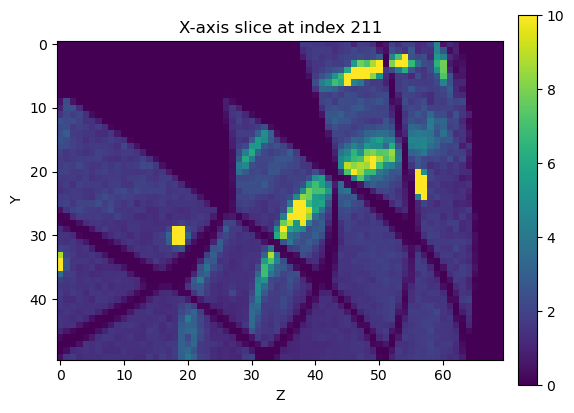

In [5]:
xslice=211
yindmin=200
yindmax=250
zindmin=180
zindmax=250

data3d=nc_sample
cbmin=0
cbmax=10
scale_mode='linear'

im=plt.imshow(data3d[xslice, yindmin:yindmax, zindmin:zindmax], cmap='viridis',vmin=cbmin,vmax=cbmax,norm=scale_mode)
plt.title(f'X-axis slice at index {xslice}')
plt.xlabel('Z')
plt.ylabel('Y')   
plt.colorbar(im,fraction=0.07,pad=0.03)
plt.show()


# peak local summation

In [27]:

peak1=nc_sample[208:213+1,220:235+1, 210:223+1]
peak1_kd=br_sample[208:213+1,220:235+1, 210:223+1]


peak2=nc_sample[166:180, 210:235, 95:120]
peak2_kd=br_sample[166:180, 210:235, 95:120]

def compare_peak(peak,peak_kd):
    ph_sample=np.max(peak)
    ph_kdtree=np.max(peak_kd)



    ph_bg=0
    ph_bg_npixel=0
    for ind,x in np.ndenumerate(peak):
        if (x<8 and x>0 ):
            ph_bg+=x
            ph_bg_npixel+=1
        
    print(ph_sample,ph_bg/ph_bg_npixel,ph_kdtree)

compare_peak(peak1,peak1_kd)
compare_peak(peak2,peak2_kd)

411.0723 2.4160708097642813 407.27188
615.24646 1.3510574950589556 615.24646


# 3D plot

In [114]:
import plotly.graph_objects as go
import numpy as np


from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display

from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import matplotlib.cm as cm

InteractiveShell.ast_node_interactivity = "all"

def int_plot3d_alpha(plot_data,plot_mask):
    def plot_3d(xmin,xmax,ymin,ymax,zmin,zmax):
        data_plt=[]
        data_trim=plot_data[xmin:xmax,ymin:ymax,zmin:zmax]
        plot_mask_trim=plot_mask[xmin:xmax,ymin:ymax,zmin:zmax]
        
        for index, x in np.ndenumerate(data_trim):
            
            if(plot_mask_trim[index]):
                data_plt.append([list(index)+[x ]])
        sp=np.array(data_plt)
        print(sp.shape)
        pltdatamax=np.max(sp[:,0,3])
        print(pltdatamax)
        colors = ['rgba({}, {}, {}, {})'.format(int(255 * val), int(206 * val), int(250 * val), 0.1) for val in sp[:,0,3]]
        print(colors)

        num_opacity=10
        # Generate a Viridis color scale
        viridis = plt.cm.get_cmap('viridis', 256)
        # Convert the color scale to RGBA format
        viridis_rgba = [mcolors.to_rgba(viridis(i)) for i in range(viridis.N)]
        colors = ['rgba({}, {}, {}, {})'.format(int(255 * val), int(206 * val), int(250 * val), 0.1) for val in sp[:,0,3]]
        
        norm = plt.Normalize(vmin=np.min(sp[:,0,3]), vmax=np.max(sp[:,0,3]))
        viridis = cm.get_cmap('viridis')
        rgba_values = viridis(norm(sp[:,0,3]))
        plt_data_percentiles = np.percentile(sp[:,0,3], range(0,100,num_opacity))
        
        rgba_values[:][3]=0
        for i in range(len(sp[:,0,3])):
                        
          rgba_values[i][3]=0.
          for critical_value in plt_data_percentiles:
            if (sp[:,0,3][i] > critical_value): rgba_values[i][3]+=1.0/num_opacity/10*10

        rgba_values[:][3]=.00
                    
        fig = go.Figure(data=[go.Scatter3d(
            x=sp[:,0,0],
            y=sp[:,0,1],
            z=sp[:,0,2],
            mode='markers',
            marker=dict(
                size=2,
                color=rgba_values
                #,                # set color to an array/list of desired values
              #  colorscale='rainbow'
                #,   # choose a colorscale
               # ,opacity=0
            )
        )])

        # tight layout
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=1))
        fig.show()



    # peak2
    xmin_widget = widgets.IntSlider(min=0, max=500, step=1, value=165, description='xmin:')
    ymin_widget = widgets.IntSlider(min=0, max=500, step=1, value=210, description='ymin:')
    zmin_widget = widgets.IntSlider(min=0, max=500, step=1, value=95, description='zmin:')

    xmax_widget = widgets.IntSlider(min=20, max=500, step=1, value=180, description='xmax:')
    ymax_widget = widgets.IntSlider(min=20, max=500, step=1, value=230, description='ymax:')
    zmax_widget = widgets.IntSlider(min=20, max=500, step=1, value=115, description='zmax:')
    
    # peak1
    ymin_widget = widgets.IntSlider(min=0, max=500, step=1, value=215, description='ymin:')
    zmin_widget = widgets.IntSlider(min=0, max=500, step=1, value=200, description='zmin:')
    xmin_widget = widgets.IntSlider(min=0, max=500, step=1, value=200, description='xmin:')

    xmax_widget = widgets.IntSlider(min=20, max=500, step=1, value=230, description='xmax:')
    ymax_widget = widgets.IntSlider(min=20, max=500, step=1, value=240, description='ymax:')
    zmax_widget = widgets.IntSlider(min=20, max=500, step=1, value=230, description='zmax:')


    peak2=nc_sample[166:180, 210:235, 100:120]
    widgets.interact(plot_3d, xmin=xmin_widget,xmax=xmax_widget,
                    ymin=ymin_widget,ymax=ymax_widget,
                    zmin=zmin_widget,zmax=zmax_widget                 )

def int_plot3d(plot_data,plot_mask):
    def plot_3d(xmin,xmax,ymin,ymax,zmin,zmax):
        data_plt=[]
        data_trim=plot_data[xmin:xmax,ymin:ymax,zmin:zmax]
        plot_mask_trim=plot_mask[xmin:xmax,ymin:ymax,zmin:zmax]
        
        for index, x in np.ndenumerate(data_trim):
            
            if(plot_mask_trim[index]):
                data_plt.append([list(index)+[np.log10(x) ]])
        sp=np.array(data_plt)
        print(sp.shape)


        fig = go.Figure(data=[go.Scatter3d(
            x=sp[:,0,0],
            y=sp[:,0,1],
            z=sp[:,0,2],
            mode='markers',
            marker=dict(
                size=2,
                color=sp[:,0,3],                # set color to an array/list of desired values
                colorscale='rainbow',   # choose a colorscale
                opacity=0.3
            )
        )])

        # tight layout
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=1))
        fig.show()



    # peak2
    xmin_widget = widgets.IntSlider(min=0, max=500, step=1, value=165, description='xmin:')
    ymin_widget = widgets.IntSlider(min=0, max=500, step=1, value=210, description='ymin:')
    zmin_widget = widgets.IntSlider(min=0, max=500, step=1, value=95, description='zmin:')

    xmax_widget = widgets.IntSlider(min=20, max=500, step=1, value=180, description='xmax:')
    ymax_widget = widgets.IntSlider(min=20, max=500, step=1, value=230, description='ymax:')
    zmax_widget = widgets.IntSlider(min=20, max=500, step=1, value=115, description='zmax:')
    
    # peak1
    ymin_widget = widgets.IntSlider(min=0, max=500, step=1, value=215, description='ymin:')
    zmin_widget = widgets.IntSlider(min=0, max=500, step=1, value=200, description='zmin:')
    xmin_widget = widgets.IntSlider(min=0, max=500, step=1, value=200, description='xmin:')

    xmax_widget = widgets.IntSlider(min=20, max=500, step=1, value=230, description='xmax:')
    ymax_widget = widgets.IntSlider(min=20, max=500, step=1, value=240, description='ymax:')
    zmax_widget = widgets.IntSlider(min=20, max=500, step=1, value=230, description='zmax:')


    peak2=nc_sample[166:180, 210:235, 100:120]
    widgets.interact(plot_3d, xmin=xmin_widget,xmax=xmax_widget,
                    ymin=ymin_widget,ymax=ymax_widget,
                    zmin=zmin_widget,zmax=zmax_widget                 )
        
def int_plot3d_alpha_matplotlib(plot_data,plot_mask):
    def plot_3d(xmin,xmax,ymin,ymax,zmin,zmax):
        data_plt=[]
        data_trim=plot_data[xmin:xmax,ymin:ymax,zmin:zmax]
        plot_mask_trim=plot_mask[xmin:xmax,ymin:ymax,zmin:zmax]
        
        for index, x in np.ndenumerate(data_trim):
            
            if(plot_mask_trim[index]):
                data_plt.append([list(index)+[x ]])
        sp=np.array(data_plt)
        print(sp.shape)
        pltdatamax=np.max(sp[:,0,3])
        print(pltdatamax)
        colors = ['rgba({}, {}, {}, {})'.format(int(255 * val), int(206 * val), int(250 * val), 0.1) for val in sp[:,0,3]]
        #print(colors)

        num_opacity=10
        # Generate a Viridis color scale
        viridis = plt.cm.get_cmap('viridis', 256)
        # Convert the color scale to RGBA format
        viridis_rgba = [mcolors.to_rgba(viridis(i)) for i in range(viridis.N)]
        colors = ['rgba({}, {}, {}, {})'.format(int(255 * val), int(206 * val), int(250 * val), 0.1) for val in sp[:,0,3]]
        
        norm = plt.Normalize(vmin=np.min(sp[:,0,3]), vmax=np.max(sp[:,0,3]))
        viridis = cm.get_cmap('viridis')
        rgba_values = viridis(norm(sp[:,0,3]))
        plt_data_percentiles = np.percentile(sp[:,0,3], range(0,100,num_opacity))
        
        rgba_values[:][3]=0
        for i in range(len(sp[:,0,3])):
          rgba_values[i][3]=0.1
          for critical_value in plt_data_percentiles:
            if (sp[:,0,3][i] > critical_value): rgba_values[i][3]+=1.0/num_opacity/10

        rgba_values[:][3]=0.1
        print(rgba_values)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        opacities = np.random.rand(len(sp[:,0,3]))

        # Step 3: Create RGBA colors with varying opacities
        colors = np.zeros((len(sp[:,0,3]), 4))
        colors[:, 0] = 0.1  # Red channel
        colors[:, 1] = 0.2  # Green channel
        colors[:, 2] = 0.5  # Blue channel
        colors[:, 3] = opacities  # Alpha channel (opacity)

        print(rgba_values)

        scatter = ax.scatter(sp[:,0,0], sp[:,0,1], sp[:,0,2], c=rgba_values)

        # Step 5: Add labels and title
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        ax.set_title('3D Scatter Plot with Individual Opacities')

        # Step 6: Show the plot
        plt.show()



    # peak2
    xmin_widget = widgets.IntSlider(min=0, max=500, step=1, value=165, description='xmin:')
    ymin_widget = widgets.IntSlider(min=0, max=500, step=1, value=210, description='ymin:')
    zmin_widget = widgets.IntSlider(min=0, max=500, step=1, value=95, description='zmin:')

    xmax_widget = widgets.IntSlider(min=20, max=500, step=1, value=180, description='xmax:')
    ymax_widget = widgets.IntSlider(min=20, max=500, step=1, value=230, description='ymax:')
    zmax_widget = widgets.IntSlider(min=20, max=500, step=1, value=115, description='zmax:')
    
    # peak1
    ymin_widget = widgets.IntSlider(min=0, max=500, step=1, value=215, description='ymin:')
    zmin_widget = widgets.IntSlider(min=0, max=500, step=1, value=200, description='zmin:')
    xmin_widget = widgets.IntSlider(min=0, max=500, step=1, value=200, description='xmin:')

    xmax_widget = widgets.IntSlider(min=20, max=500, step=1, value=230, description='xmax:')
    ymax_widget = widgets.IntSlider(min=20, max=500, step=1, value=240, description='ymax:')
    zmax_widget = widgets.IntSlider(min=20, max=500, step=1, value=230, description='zmax:')


    peak2=nc_sample[166:180, 210:235, 100:120]
    widgets.interact(plot_3d, xmin=xmin_widget,xmax=xmax_widget,
                    ymin=ymin_widget,ymax=ymax_widget,
                    zmin=zmin_widget,zmax=zmax_widget                 )
int_plot3d_alpha_matplotlib(nc_sample,mask)
int_plot3d_alpha(nc_sample,mask)

interactive(children=(IntSlider(value=200, description='xmin:', max=500), IntSlider(value=230, description='xm…

interactive(children=(IntSlider(value=200, description='xmin:', max=500), IntSlider(value=230, description='xm…

In [48]:
int_plot3d(nc_sample,mask)

#peak2=nc_sample[166:180, 210:235, 95:120]

interactive(children=(IntSlider(value=200, description='xmin:', max=500), IntSlider(value=230, description='xm…